In [1]:
import numpy as np # library to handle data in a vectorized manner
!pip install geopy

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [3]:
ny_data=get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(ny_data['Borough'].unique()),
        ny_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [6]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Borough'], ny_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [7]:

CLIENT_ID = 'BPNFM0H2GWAF3ZO3BY4B2VBJII1BA4GE04XNN3QOTOS1HLB2' # your Foursquare ID
CLIENT_SECRET = 'SBSX2YY14L0M134I0DCNJQV3UZIAGZ21I4RFGY5K2HFEWLYF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BPNFM0H2GWAF3ZO3BY4B2VBJII1BA4GE04XNN3QOTOS1HLB2
CLIENT_SECRET:SBSX2YY14L0M134I0DCNJQV3UZIAGZ21I4RFGY5K2HFEWLYF


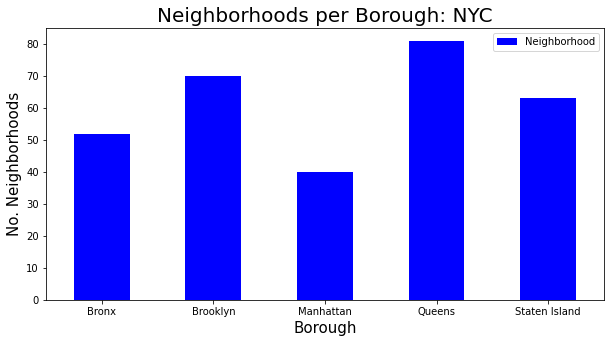

In [8]:
import matplotlib.pyplot as plt
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [13]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, latitude, longitude=row
    venues = get_venues(latitude,longitude)
    italian_rest=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Restaurant in '+Neighborhood+', '+Borough+':'+str(len(italian_rest)))
    print(row)
    for bar_detail in italian_rest.values.tolist():
        id, name , category=bar_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
        
    count+=1

( 1 / 306 ) Italian Restaurant in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Restaurant in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Restaurant in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Restaurant in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Restaurant in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Restaurant in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Restaurant in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Restaurant in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Restaurant in Norwood, Bronx:0
['Bronx', '

In [14]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv')

In [15]:

italian_ny = pd.read_csv('italian_rest_ny_tocsv1.csv')
italian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
208,Manhattan,Flatiron,53370455498e18d7e6607a1d,La Pizza & La Pasta
209,Manhattan,Flatiron,4b741ab4f964a5202cc82de3,Novità Cucina Creativa
210,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
211,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
212,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [16]:
italian_rest_ny.shape

(213, 4)

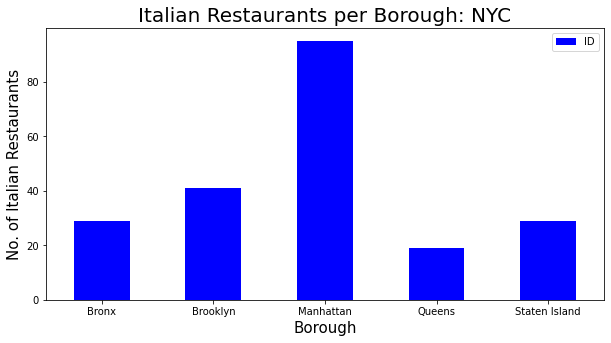

In [17]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

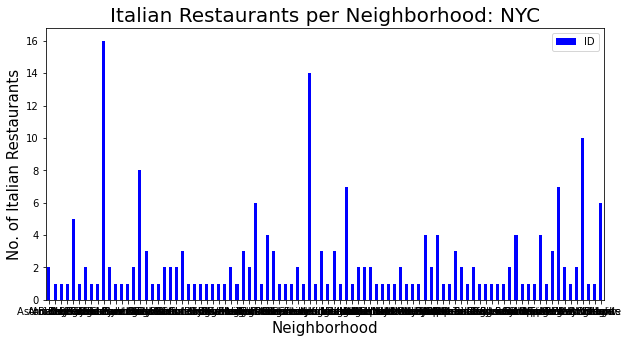

In [18]:
italian_rest_ny.groupby('Neighborhood')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [21]:

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60c2ad80948d0065fb61a7f6'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}, {'label': 'entrance', 'lat': 40.900601, 'lng': -73.867611}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}],

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
208,Manhattan,Flatiron,53370455498e18d7e6607a1d,La Pizza & La Pasta,199,8.0,57
209,Manhattan,Flatiron,4b741ab4f964a5202cc82de3,Novità Cucina Creativa,112,8.4,41
210,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's,131,8.4,73
211,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's,131,8.4,73
212,Staten Island,Lighthouse Hill,0,0,0,0.0,0


In [22]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv')

In [23]:
italian_rest_stats_ny.shape

(213, 7)

In [24]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       213 non-null    object 
 1   Neighborhood  213 non-null    object 
 2   ID            213 non-null    object 
 3   Name          213 non-null    object 
 4   Likes         213 non-null    object 
 5   Rating        213 non-null    float64
 6   Tips          213 non-null    object 
dtypes: float64(1), object(6)
memory usage: 11.8+ KB


In [25]:
italian_rest_stats_ny['Likes'] = italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips'] = italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       213 non-null    object 
 1   Neighborhood  213 non-null    object 
 2   ID            213 non-null    object 
 3   Name          213 non-null    object 
 4   Likes         213 non-null    float64
 5   Rating        213 non-null    float64
 6   Tips          213 non-null    float64
dtypes: float64(3), object(4)
memory usage: 11.8+ KB


In [26]:
italian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,213.000000,213.000000,213.000000
mean,120.615023,7.150235,51.619718
std,239.058772,2.411541,108.358424
min,0.000000,0.000000,0.000000
25%,14.000000,7.200000,7.000000
50%,35.000000,7.900000,18.000000
75%,109.000000,8.400000,42.000000
max,1449.000000,9.300000,1136.000000


In [27]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4afb2990f964a520a91b22e3
Name                            Maialino
Likes                               1449
Rating                               7.9
Tips                                 467
Name: 137, dtype: object

In [28]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              4a27289cf964a52062911fe3
Name                            L'Artusi
Likes                               1176
Rating                               9.3
Tips                                 372
Name: 126, dtype: object

In [29]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 22
Rating                               8.5
Tips                                1136
Name: 157, dtype: object

In [30]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
13,Bushwick,9.2
8,Bedford Stuyvesant,9.1
44,Hamilton Heights,9.0
82,Tribeca,8.9
11,Boerum Hill,8.9
25,Concourse Village,8.8
78,South Side,8.8
73,Rego Park,8.7
21,Clinton Hill,8.6
66,North Side,8.6


In [31]:

ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.094737
0,Bronx,7.379310
3,Queens,7.094737
1,Brooklyn,6.804878
4,Staten Island,4.351724


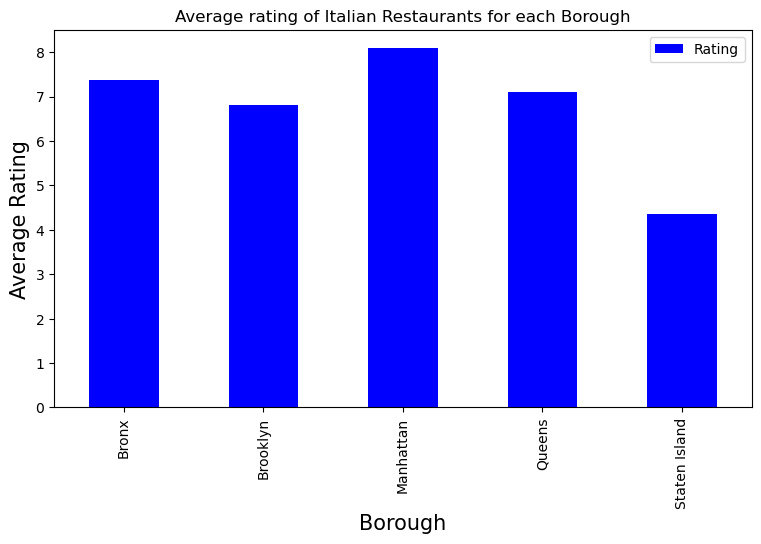

In [32]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Italian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [33]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Auburndale,8.200000
8,Bedford Stuyvesant,9.100000
11,Boerum Hill,8.900000
13,Bushwick,9.200000
18,City Island,8.300000
21,Clinton Hill,8.600000
22,Cobble Hill,8.033333
25,Concourse Village,8.800000
26,Corona,8.500000
28,Dumbo,8.400000


In [34]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Auburndale,40.761730,-73.791762,8.200000
1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,9.100000
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.900000
3,Brooklyn,Bushwick,40.698116,-73.925258,9.200000
4,Bronx,City Island,40.847247,-73.786488,8.300000
5,Brooklyn,Clinton Hill,40.693229,-73.967843,8.600000
6,Brooklyn,Cobble Hill,40.687920,-73.998561,8.033333
7,Bronx,Concourse Village,40.824780,-73.915847,8.800000
8,Queens,Corona,40.742382,-73.856825,8.500000
9,Brooklyn,Dumbo,40.703176,-73.988753,8.400000


In [35]:

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [36]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)